In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [76]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/P1_data.csv', delimiter=';', decimal=',')

# Show the first few rows of the DataFrame to confirm it's loaded correctly
print(df.head())

   ik1  ik2  ik3  ivb  rtim_1    rtim_2  rtim_3    rtim_4    rtim_5  rtim_6  \
0    1    1    1    1   0.125  0.291667   0.375  0.458333  0.583333    0.75   
1    1    1    1    1   0.125  0.291667   0.375  0.458333  0.583333    0.75   
2    1    1    1    1   0.125  0.291667   0.375  0.458333  0.583333    0.75   
3    1    1    1    1   0.125  0.291667   0.375  0.458333  0.583333    0.75   
4    1    1    1    1   0.125  0.291667   0.375  0.458333  0.583333    0.75   

   ...   tac_19   tac_20   tac_21   tac_22    k1     k2     k3  vb  nn  \
0  ...  9.01873  9.07621  9.16739  9.28509  0.13  0.014  0.025   0   0   
1  ...  9.01873  9.07621  9.16739  9.28509  0.13  0.014  0.025   0   0   
2  ...  9.01873  9.07621  9.16739  9.28509  0.13  0.014  0.025   0   0   
3  ...  9.01873  9.07621  9.16739  9.28509  0.13  0.014  0.025   0   0   
4  ...  9.01873  9.07621  9.16739  9.28509  0.13  0.014  0.025   0   0   

         ki  
0  0.083333  
1  0.083333  
2  0.083333  
3  0.083333  
4  0.08333

In [77]:
def DataLoader(row, df):
    """
    Extracts rtim_list, pl_list, bl_list, tac_list, and ground truth parameters list from a given row of the dataset.

    Parameters:
    row (int): The index of the row in the dataframe from which to extract the data.
    df (pandas.DataFrame): The dataframe containing the dataset.

    Returns:
    dict: A dictionary containing the extracted lists and ground truth parameters.
    """
    # Initialize lists
    rtim_list = []
    pl_list = []
    bl_list = []
    tac_list = []
    gt_parameters_list = []

    # Extract rtim_, pl_, bl_, and tac_ values from the row
    for column in df.columns:
        if column.startswith('rtim_'):
            rtim_list.append(df.at[row, column])
        elif column.startswith('pl_') and not column.endswith('23'):  # Exclude the 23rd column for plasma
            pl_list.append(df.at[row, column])
        elif column.startswith('bl_') and not column.endswith('23'):  # Exclude the 23rd column for blood
            bl_list.append(df.at[row, column])
        elif column.startswith('tac_'):
            tac_list.append(df.at[row, column])
        elif column in ['k1', 'k2', 'k3', 'vb']:  # Ground truth parameters
            gt_parameters_list.append(df.at[row, column])

    # Return the lists and ground truth parameters in a dictionary
    return {
        'rtim_list': rtim_list,
        'pl_list': pl_list,
        'bl_list': bl_list,
        'tac_list': tac_list,
        'gt_parameters_list': gt_parameters_list
    }

In [78]:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

# Print length of dicionary lists to verify that they are all the same length
print(len(data_from_first_row['rtim_list']))
print(len(data_from_first_row['pl_list']))
print(len(data_from_first_row['bl_list']))
print(len(data_from_first_row['tac_list']))

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.000447092, 1.19203, 2.23593, 2.98451, 3.7924, 4.66501, 5.35297, 6.86292, 8.05328, 8.58368, 8.8618, 9.11187, 9.24098, 9.2836, 9.2275, 9.11599, 9.01852, 8.99301, 9.01873, 9.07621, 9.16739, 9.28509], 'gt_parameters_list': [0.13, 0.014, 0.025, 0]}
22
22
22
22


In [79]:
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator

def equidistant_interpolation(rtim_list, pl_list, num_points):
    """
    Performs equidistant interpolation on the given rtim_list and pl_list.

    Parameters:
    rtim_list (list): The original list of non-equidistant timepoints.
    pl_list (list): The list of plasma concentration values corresponding to rtim_list.
    num_points (int): The number of desired equidistant points.

    Returns:
    tuple: Lists containing the new equidistant timepoints and interpolated plasma values.
    """
    # Generate equidistant timepoints
    min_time = min(rtim_list)
    max_time = max(rtim_list) + 5  # Add 5 to max_time to ensure the last timepoint is included
    equidistant_rtim = np.linspace(min_time, max_time, num_points)

    # Perform linear interpolation using numpy
    linear_interp_pl = np.interp(equidistant_rtim, rtim_list, pl_list)

    # Perform cubic interpolation using scipy (as an alternative example)
    cubic_interp_func = interp1d(rtim_list, pl_list, kind='cubic', fill_value="extrapolate")
    cubic_interp_pl = cubic_interp_func(equidistant_rtim)

    # Perform monotonic cubic interpolation using PchipInterpolator
    pchip_interp_func = PchipInterpolator(rtim_list, pl_list)
    pchip_interp_pl = pchip_interp_func(equidistant_rtim)

    return equidistant_rtim, linear_interp_pl, cubic_interp_pl, pchip_interp_pl

In [80]:
# Example usage:
num_equidistant_points = 10000
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                        data_from_first_row['pl_list'],
                                                        num_equidistant_points)

In [81]:
def plot_interpolations(rtim_list, pl_list, new_rtim, linear_pl, cubic_pl, pchip_pl, Type):
    """
    Plots the original plasma concentration values and the interpolated values.

    Parameters:
    rtim_list (list): Original list of timepoints.
    pl_list (list): Original list of plasma concentration values.
    new_rtim (list): Equidistant timepoints.
    linear_pl (list): Plasma concentration values interpolated linearly.
    cubic_pl (list): Plasma concentration values interpolated using cubic spline.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    Type (str): The type of data being plotted.
    """
    plt.figure(figsize=(10, 6))

    # Plot original data
    plt.plot(rtim_list, pl_list, 'o-', label='Original Data', color='blue')

    # Plot linear interpolation
    plt.plot(new_rtim, linear_pl, label='Linear Interpolation', color='red')

    # Plot cubic interpolation
    plt.plot(new_rtim, cubic_pl, label='Cubic Interpolation', color='green')

    # Plot pchip interpolation
    plt.plot(new_rtim, pchip_pl, label='PCHIP Interpolation', color='orange')

    plt.xlabel('Time')
    plt.ylabel(Type + ' Concentration')
    plt.title(Type + ' Concentration vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

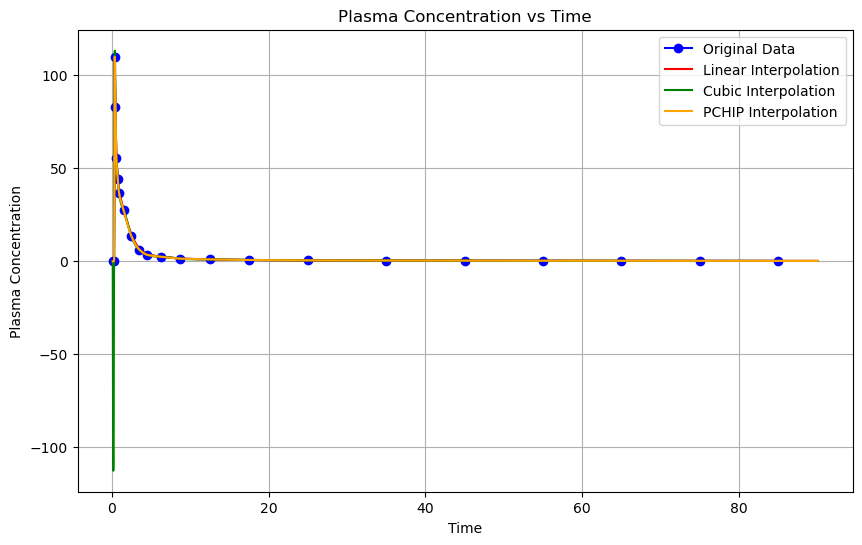

In [82]:
plot_interpolations(data_from_first_row['rtim_list'], 
                        data_from_first_row['pl_list'], 
                        new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

In [83]:
def IRF(gt_parameters_list, equidistant_rtim):
    """
    Calculates the impulse response function (IRF) for the given ground truth parameters and equidistant timepoints.

    Parameters:
    gt_parameters_list (list): List of ground truth parameters.
    equidistant_rtim (list): Equidistant timepoints.

    Returns:
    list: The IRF values.
    """
    # Extract ground truth parameters
    k1 = gt_parameters_list[0]
    k2 = gt_parameters_list[1]
    k3 = gt_parameters_list[2]
    k4 = 0 # For the current data, k4 is always 0

    # Calculate alphas:
    alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha1 /= 2

    alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha2 /= 2

    # Calculate IRF
    IRF = []
    for t in equidistant_rtim:
        value = ( (k3 + k4 - alpha1) * np.exp(-alpha1 * t) + (alpha2 - k3 - k4) * np.exp(-alpha2 * t) ) / (alpha2 - alpha1)
        value *= k1
        IRF.append(value)
    
    return IRF

In [84]:
# Example usage
IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)
# print(IRF_values)

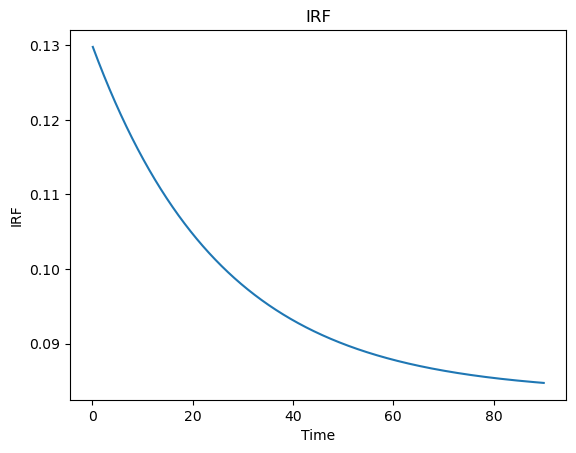

In [85]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

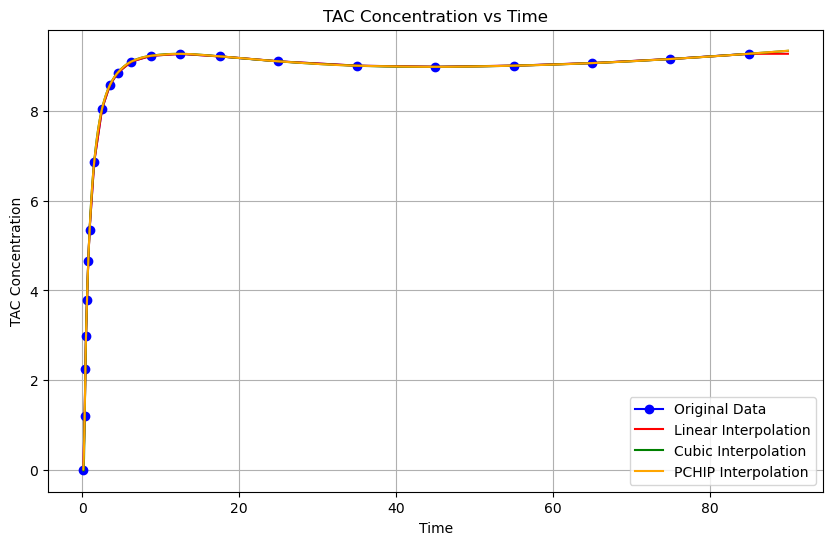

In [86]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

In [87]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_result_tensor = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_result_tensor


In [88]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

#print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 10000
IRF: 10000
10000


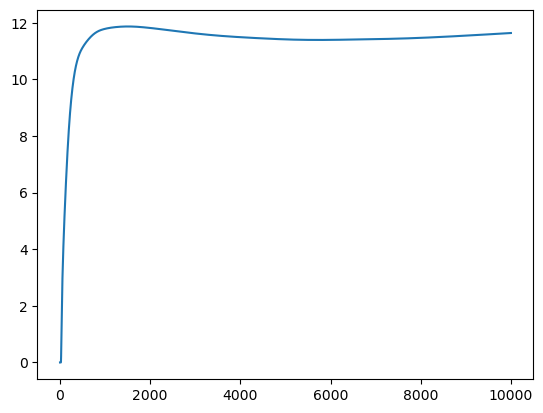

In [89]:
plt.plot(simulated_c_tissue_values)
plt.show()

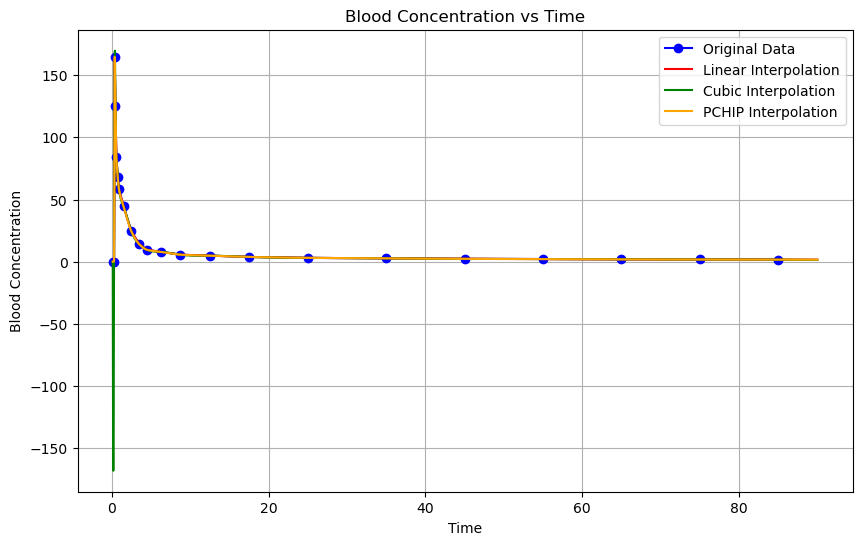

In [90]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [91]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values

Simulated TAC: [1.255664812384729e-15, 1.427364142583958e-07, 7.237096447359282e-07, 2.0534512445857822e-06, 4.457522041353247e-06, 8.276510267290813e-06, 1.3866029666652736e-05, 2.159671764651934e-05, 3.185423338241735e-05, 4.5039255947797895e-05, 6.156748244560726e-05, 8.186962614069472e-05, 0.00010639141457422265, 0.00013559358770360826, 0.00016995189602614185, 0.0002099570987164174, 0.00025611496175078784, 0.00030894625604019143, 0.0003689867555654897, 0.0013427844306372176, 0.009929100196993916, 0.03226302014506975, 0.07254783624215749, 0.13305528879621883, 0.21412580883474364, 0.3141687603986381, 0.42966268275120906, 0.5551555325022471, 0.6833950632262351, 0.8106005172155051, 0.9355077806524222, 1.0571326885082741, 1.1747709893956733, 1.2879983104332937, 1.3966701221229034, 1.500921703238731, 1.6011681057291198, 1.698104119630487, 1.7922394115071767, 1.8835647024105147, 1.972089074257824, 2.057843649613504, 2.1408815889248918, 2.2212780877591354, 2.2991303740409923, 2.37455770529

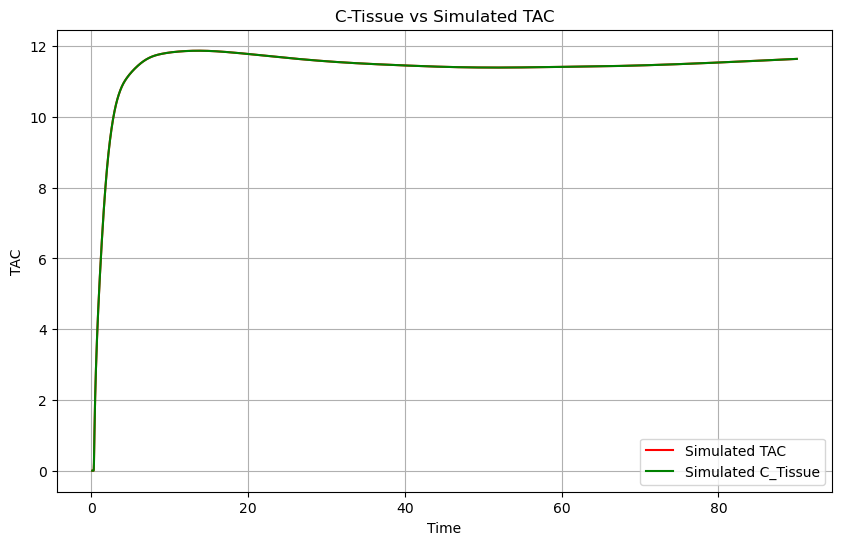

In [92]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)
print("Simulated TAC:", simulated_tac_values)
print("CTissue:" , simulated_c_tissue_values)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

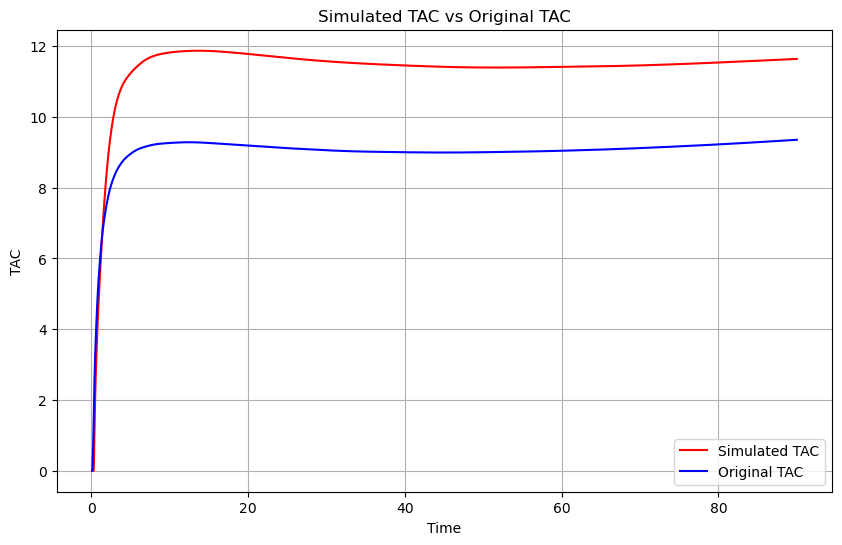

1.2443955548291874
1.2443955548291874


In [93]:
# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()
print(simulated_c_tissue_values[-1]/pchip_tac[-1])

print(simulated_c_tissue_values[-1]/pchip_tac[-1])